# Dog Breed Classication using AWS Sagemaker
This project uses AWS sage maker to make a classification for 133 classes of dog breeds using a pre-trained model (Resnet 50). <br>
I go over 3 primary step <br>
* Data Preparation step
    * Prepare dog image 
    * upload to S3 
* Training step
    * Hyperparameter Tuning 
    * Train a best performance model and test it 
    * Debugger and Profile Report 
* Deploying step 
    * deploy the model and test it 

In [4]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [5]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)
from  sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule, 
    ProfilerRule, 
    rule_configs,
    DebuggerHookConfig, 
    ProfilerConfig, 
    FrameworkProfile,
    CollectionConfig
)


## Dataset
The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-10-02 19:49:21--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.240
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  27.5MB/s    in 28s     

2022-10-02 19:49:50 (38.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [6]:
import os
all_classes = [name.split('.') for name in os.listdir("dogImages/train")]
all_classes = dict(all_classes)
all_classes

{'073': 'German_wirehaired_pointer',
 '074': 'Giant_schnauzer',
 '025': 'Black_and_tan_coonhound',
 '108': 'Norwegian_buhund',
 '072': 'German_shorthaired_pointer',
 '075': 'Glen_of_imaal_terrier',
 '011': 'Australian_cattle_dog',
 '014': 'Basenji',
 '107': 'Norfolk_terrier',
 '016': 'Beagle',
 '090': 'Italian_greyhound',
 '027': 'Bloodhound',
 '038': 'Brussels_griffon',
 '018': 'Beauceron',
 '058': 'Dandie_dinmont_terrier',
 '118': 'Pembroke_welsh_corgi',
 '124': 'Poodle',
 '001': 'Affenpinscher',
 '125': 'Portuguese_water_dog',
 '114': 'Otterhound',
 '053': 'Cocker_spaniel',
 '109': 'Norwegian_elkhound',
 '086': 'Irish_setter',
 '103': 'Mastiff',
 '093': 'Kerry_blue_terrier',
 '029': 'Border_collie',
 '105': 'Neapolitan_mastiff',
 '112': 'Nova_scotia_duck_tolling_retriever',
 '126': 'Saint_bernard',
 '021': 'Belgian_sheepdog',
 '116': 'Parson_russell_terrier',
 '013': 'Australian_terrier',
 '040': 'Bulldog',
 '063': 'English_springer_spaniel',
 '131': 'Wirehaired_pointing_griffon',
 

In [7]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "project/dog-image"
role = sagemaker.get_execution_role()

In [8]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-west-2-145734293004/project/dog-image


## Hyperparameter Tuning

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_range = {
        "lr" : ContinuousParameter(0.001,0.1),
        "batch-size" : CategoricalParameter([32,64,128,256,512]),
        "epochs" : IntegerParameter(6,8)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definition = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [10]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    #instance_type="ml.g4dn.xlarge"
    instance_type="ml.m5.12xlarge"
)


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_range,
    metric_definition,
    max_jobs=8,
    max_parallel_jobs=2,
    objective_type = objective_type
)

In [11]:
"s3://{}/{}".format(bucket, prefix) + "/train"

's3://sagemaker-us-west-2-145734293004/project/dog-image/train'

In [12]:
# TODO: Fit your HP Tuner
tuner.fit({
        "train" : "s3://{}/{}".format(bucket, prefix) + "/train" , 
        "test" : "s3://{}/{}".format(bucket, prefix) + "/test",
        "val" : "s3://{}/{}".format(bucket, prefix) + "/valid"}) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [13]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-12 22:27:17 Starting - Found matching resource for reuse
2023-03-12 22:27:17 Downloading - Downloading input data
2023-03-12 22:27:17 Training - Training image download completed. Training in progress.
2023-03-12 22:27:17 Uploading - Uploading generated training model
2023-03-12 22:27:17 Completed - Resource reused by training job: pytorch-training-230312-2110-008-63874b7e


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'epochs': '7',
 'lr': '0.0011326071316402377',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-12-21-10-34-681"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-west-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-west-2-145734293004/pytorch-training-2023-03-12-21-10-34-681/source/sourcedir.tar.gz"'}

In [14]:
# Because the session ended and took a long time to tune, I got the job name from the console 
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName="pytorch-training-230312-2110"
)["BestTrainingJob"]

{'TrainingJobName': 'pytorch-training-230312-2110-005-6faf9072',
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:145734293004:training-job/pytorch-training-230312-2110-005-6faf9072',
 'CreationTime': datetime.datetime(2023, 3, 12, 22, 2, 42, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2023, 3, 12, 22, 2, 45, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2023, 3, 12, 22, 26, 42, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'batch-size': '"128"',
  'epochs': '7',
  'lr': '0.0011326071316402377'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'average test loss',
  'Value': 0.6075000166893005},
 'ObjectiveStatus': 'Succeeded'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [15]:
# TODO: Set up debugging and profiling rules and hooks
hyperparameters = {"epochs": 7, "batch-size": 128, "lr": 0.0011326071316402377}
#https://knowledge.udacity.com/questions/749611

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[
    CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
                "include_regex": "CrossEntropyLoss_output_0", 
                "train.save_interval": "100","eval.save_interval": "10"})
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))
debug_config = DebuggerHookConfig(collection_configs=collection_configs)

In [16]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dogImages-pytorch",
    role=role,
    instance_count=1,
    instance_type="ml.m5.12xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    rules=rules,
    debugger_hook_config=debug_config,
    profiler_config=profiler_config
)
estimator.fit({
        "train" : "s3://{}/{}".format(bucket, prefix) + "/train" , 
        "test" : "s3://{}/{}".format(bucket, prefix) + "/test",
        "eval" : "s3://{}/{}".format(bucket, prefix) + "/valid"}, wait = True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923


2023-03-12 22:58:40 Starting - Starting the training job...
2023-03-12 22:59:10 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
...
2023-03-12 22:59:39 Downloading - Downloading input data......
2023-03-12 23:00:30 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-12 23:00:54,597 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-12 23:00:54,599 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-12 23:00:54,607 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-12 23:00:54,609 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-12 23:00:54,783 sagemaker-training-toolkit INFO     N

In [17]:
# TODO: Plot a debugging output.
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Training jobname: smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923
Region: us-west-2
[2023-03-12 23:51:21.461 ip-172-16-69-6.us-west-2.compute.internal:11029 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-12 23:51:21.475 ip-172-16-69-6.us-west-2.compute.internal:11029 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-145734293004/smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/debug-output
[2023-03-12 23:51:22.177 ip-172-16-69-6.us-west-2.compute.internal:11029 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-12 23:51:23.195 ip-172-16-69-6.us-west-2.compute.internal:11029 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias',

In [18]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


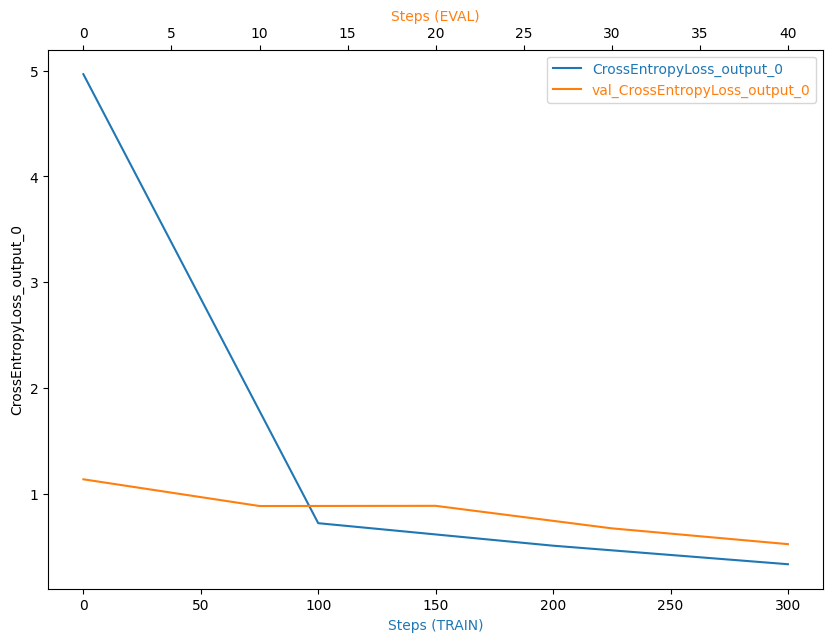

In [20]:
plot_tensor(trial, "CrossEntropyLoss_output_0")


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [21]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [22]:
! aws s3 ls {rule_output_path} --recursive

2023-03-12 23:45:50     375999 smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-12 23:45:48     223975 smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-12 23:45:43        192 smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-12 23:45:43        200 smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-12 23:45:43       1896 smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-12 23:45:43        127 smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-12 23:45:43        199 smdebugger-dogImages-py

In [23]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-west-2-145734293004/smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-west-2-145734293004/smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-west-2-145734293004/smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-west-2-145734293004/smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
downlo

In [24]:
import os
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [25]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [26]:
import shutil
shutil.make_archive("./profiler_repot", "zip", "ProfilerReport")

'/home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_repot.zip'

## Model Deploying

In [27]:
model_location = estimator.model_data
model_location

's3://sagemaker-us-west-2-145734293004/smdebugger-dogImages-pytorch-2023-03-12-22-58-39-923/output/model.tar.gz'

In [28]:
import smdebug
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [29]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [30]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py', py_version='py36',
                             framework_version='1.6',
                             predictor_cls=ImagePredictor)


In [31]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-12-23-58-39-473
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-12-23-58-40-126
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-12-23-58-40-126


------!

In [39]:
# TODO: Run an prediction on the endpoint
with open ("dogImages/valid/014.Basenji/Basenji_00967.jpg" , 'rb') as f :
    image = f.read()

In [40]:
response=predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
response

[[-10.145936012268066,
  -10.53530502319336,
  -10.669340133666992,
  -1.8255647420883179,
  -8.659235954284668,
  -8.884302139282227,
  -3.8312392234802246,
  -5.957025527954102,
  -9.184228897094727,
  -7.281717300415039,
  -3.2968268394470215,
  -9.40891170501709,
  -6.493511199951172,
  -0.34980863332748413,
  -8.291141510009766,
  -9.043662071228027,
  -9.379549980163574,
  -10.28385066986084,
  -6.96937894821167,
  -7.903964996337891,
  -8.721949577331543,
  -9.531302452087402,
  -12.009053230285645,
  -6.865390777587891,
  -10.145763397216797,
  -11.955339431762695,
  -8.629903793334961,
  -11.190555572509766,
  -11.731250762939453,
  -8.82163143157959,
  -8.829241752624512,
  -11.188956260681152,
  -9.004228591918945,
  -11.611870765686035,
  -11.116459846496582,
  -10.36090087890625,
  -8.446121215820312,
  -9.909785270690918,
  -2.8463199138641357,
  -8.152130126953125,
  -9.0843505859375,
  -10.621506690979004,
  -0.4459574222564697,
  -8.828522682189941,
  -4.04266977310180

In [41]:
import numpy as np 
np.argmax(response)+1

14

In [42]:
# TODO: Run an prediction on the endpoint
with open ("dogImages/valid/016.Beagle/Beagle_01126.jpg" , 'rb') as f :
    image = f.read()

In [45]:
response=predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
#response

In [46]:
import numpy as np 
np.argmax(response)+1

7

In [50]:
# TODO: Run an prediction on the endpoint
with open ("dogImages/valid/031.Borzoi/Borzoi_02173.jpg" , 'rb') as f :
    image = f.read()

In [51]:
response=predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
#response

In [52]:
import numpy as np 
np.argmax(response)+1

94

In [59]:
# TODO: Run an prediction on the endpoint
with open ("dogImages/test/039.Bull_terrier/Bull_terrier_02750.jpg" , 'rb') as f :
    image = f.read()

In [60]:
response=predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
#response

In [61]:
import numpy as np 
np.argmax(response)+1

39

## Result:

#### Model deployed has accuracy of 83%

#### From Validation Set:
    Model identified the label for Basenji dog breed correctly.
    Label 11 (Beagle) was identified incorrectly as label 7 (American Foxhound).
    Label 31 (Borzoi) was identified incorrectly as label 94 (Komondor)
    
#### From Test Set:
    Model identified the label 39 for Bull Terrier dog breed correctly.

In [62]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-12-23-58-40-126
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-12-23-58-40-126
